In [1]:
import umap
import torch
from torch.functional import F
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm

from common import h5dataset, model_dnn

c:\Users\sollb\Documents\fhnw\ip5\IP5-Jass-AI\training\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET_PATH = '../log_parser/dataset/flat_playing.hdf5'
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATASET_PATH}")

MODLE_PATH = './models/'
if not os.path.exists(MODLE_PATH):
    os.makedirs(MODLE_PATH)


In [3]:
BATCH_SIZE = 256
NUM_ACTIONS = 9
SEED = 42

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
dataset = h5dataset.H5Dataset(DATASET_PATH)
train_dataset, val_dataset = dataset.split(0.99)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)


# Load model
model_gan_untrained = model_dnn.ModelDNN(
    "JassPlayGenUntrained",
    input_size=72,
    embedding_size=13,
    hidden_size=[1024, 512, 256, 128],
    output_size=9,
)
model_gan_untrained.to(device)

model_gan = model_dnn.ModelDNN(
    "JassPlayGen",
    input_size=72,
    embedding_size=13,
    hidden_size=[1024, 512, 256, 128],
    output_size=9,
)
model_gan.load_state_dict(torch.load(os.path.join(MODLE_PATH, 'play_gan', 'JassGanGen_1024_512_256_128_dnn.pth')))
model_gan.to(device)
model_gan.eval()
embedding_gan = model_gan.embedding



model_sl = model_dnn.ModelDNN(
    "JassPlaySL",
    input_size=72,
    embedding_size=13,
    hidden_size=[512, 256, 128],
    output_size=9,
)

model_sl.load_state_dict(torch.load(os.path.join(MODLE_PATH, 'play', 'JassPlay_512_256_128_dnn.pth')))
model_sl.to(device)
model_sl.eval()


ModelDNN(
  (embedding): Embedding(37, 13)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=936, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=9, bias=True)
  )
)

In [4]:
# Containers
def create_state_action(model, loader):
    fake_combined = []
    real_combined = []
    real_labels = []
    fake_labels = []
    with torch.no_grad():
        
        for state, action in tqdm(loader, desc=f"Creating vectors for {model.name}", unit="batch"):
            state, action = state.to(device), action.to(device)

            # Get action predictions
            logits = model(state)
            fake_actions = logits.argmax(dim=1)

            em_state =  embedding_gan(state)

            # remove history from state [0:31] and other hands [43:70]
            # stat is [32:42] and [71:71]
            em_state = torch.cat([em_state[:, 32:42], em_state[:, 71:72]], dim=1)
            # take the embedding of the action. it is n index in the embedded state
            em_fake_actions = em_state.gather(1, fake_actions.view(-1, 1).unsqueeze(-1).expand(-1, -1, em_state.size(2))).squeeze(1)
            em_real_actions = em_state.gather(1, action.view(-1, 1).unsqueeze(-1).expand(-1, -1, em_state.size(2))).squeeze(1)

            real_labels_batch = state.gather(1, (action + 32).view(-1, 1)) - 1
            fake_labels_batch = state.gather(1, (fake_actions + 32).view(-1, 1)) - 1

            # flatten the state
            em_state = em_state.view(em_state.size(0), -1)

            # Combine input (state) with action vector
            fake_combined.append(torch.cat([em_state.cpu(), em_fake_actions.cpu()], dim=1))
            real_combined.append(torch.cat([em_state.cpu(), em_real_actions.cpu()], dim=1))
            real_labels.append(real_labels_batch.cpu())
            fake_labels.append(fake_labels_batch.cpu())

    fake_combined = torch.cat(fake_combined, dim=0)
    real_combined = torch.cat(real_combined, dim=0)

    return fake_combined.numpy(), fake_labels, real_combined.numpy(), real_labels

gan_fake, gan_fake_labels, gan_real, gan_real_labels = create_state_action(model_sl, val_loader)
gan_untrained_fake, gan_untrained_fake_labels, gan_untrained_real, gan_untrained_real_labels = create_state_action(model_gan_untrained, val_loader)


Creating vectors for JassPlaySL_512_256_128_dnn: 100%|██████████| 867/867 [00:06<00:00, 144.48batch/s]
Creating vectors for JassPlayGenUntrained_1024_512_256_128_dnn: 100%|██████████| 867/867 [00:05<00:00, 149.48batch/s]


In [5]:
def reducer(vecs):
    umap.tqdm_progress = tqdm(total=vecs.shape[0], desc="UMAP embedding", unit="sample")
    reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2, verbose=True, tqdm_kwds={'desc': 'UMAP fit', 'leave': True})
    embedding = reducer.fit_transform(vecs)
    return embedding

all_vecs_gan = np.vstack([gan_fake, gan_real])
gan_labels = gan_fake_labels + gan_real_labels
all_vecs_untrained = np.vstack([gan_untrained_fake, gan_untrained_real])
gan_untrained_labels = gan_untrained_fake_labels + gan_untrained_real_labels
embedding_gan = reducer(all_vecs_gan)
embedding_untrained = reducer(all_vecs_untrained)

UMAP embedding:   0%|          | 0/443544 [00:00<?, ?sample/s]

UMAP(n_neighbors=10, verbose=True)
Wed Aug  6 18:58:27 2025 Construct fuzzy simplicial set
Wed Aug  6 18:58:27 2025 Finding Nearest Neighbors
Wed Aug  6 18:58:27 2025 Building RP forest with 38 trees
Wed Aug  6 18:58:35 2025 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	 3  /  19
	 4  /  19
	 5  /  19
	 6  /  19
	Stopping threshold met -- exiting after 6 iterations
Wed Aug  6 18:58:46 2025 Finished Nearest Neighbor Search
Wed Aug  6 18:58:48 2025 Construct embedding


	completed  0  /  200 epochs


	completed  20  /  200 epochs


	completed  40  /  200 epochs


	completed  60  /  200 epochs


	completed  80  /  200 epochs


	completed  100  /  200 epochs


	completed  120  /  200 epochs


	completed  140  /  200 epochs


	completed  160  /  200 epochs


	completed  180  /  200 epochs


UMAP fit: 100%| ██████████ 200/200 [00:12]


Wed Aug  6 19:17:28 2025 Finished embedding


UMAP embedding:   0%|          | 0/443544 [19:02<?, ?sample/s]


UMAP(n_neighbors=10, verbose=True)
Wed Aug  6 19:17:30 2025 Construct fuzzy simplicial set
Wed Aug  6 19:17:30 2025 Finding Nearest Neighbors
Wed Aug  6 19:17:30 2025 Building RP forest with 38 trees
Wed Aug  6 19:17:34 2025 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	 3  /  19
	 4  /  19
	 5  /  19
	 6  /  19
	Stopping threshold met -- exiting after 6 iterations
Wed Aug  6 19:17:40 2025 Finished Nearest Neighbor Search
Wed Aug  6 19:17:41 2025 Construct embedding


UMAP fit:   2%| ▏          4/200 [00:00]

	completed  0  /  200 epochs


UMAP fit:  11%| █          22/200 [00:01]

	completed  20  /  200 epochs


UMAP fit:  22%| ██▏        44/200 [00:02]

	completed  40  /  200 epochs


UMAP fit:  32%| ███▏       64/200 [00:03]

	completed  60  /  200 epochs


UMAP fit:  42%| ████▏      84/200 [00:04]

	completed  80  /  200 epochs


UMAP fit:  52%| █████▏     104/200 [00:05]

	completed  100  /  200 epochs


UMAP fit:  62%| ██████▏    124/200 [00:06]

	completed  120  /  200 epochs


UMAP fit:  72%| ███████▏   144/200 [00:07]

	completed  140  /  200 epochs


UMAP fit:  81%| ████████   162/200 [00:09]

	completed  160  /  200 epochs


UMAP fit:  92%| █████████▏ 184/200 [00:10]

	completed  180  /  200 epochs


UMAP fit: 100%| ██████████ 200/200 [00:11]


Wed Aug  6 19:19:10 2025 Finished embedding


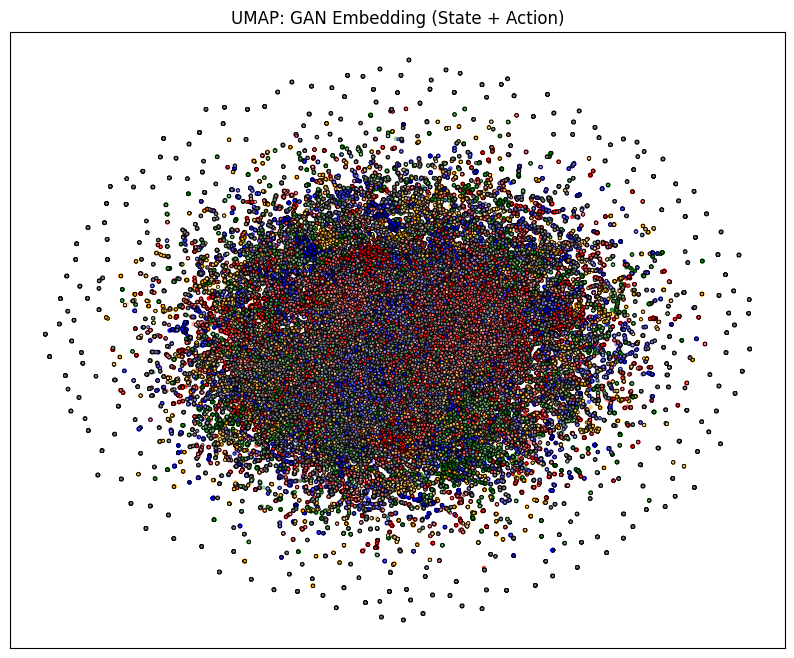

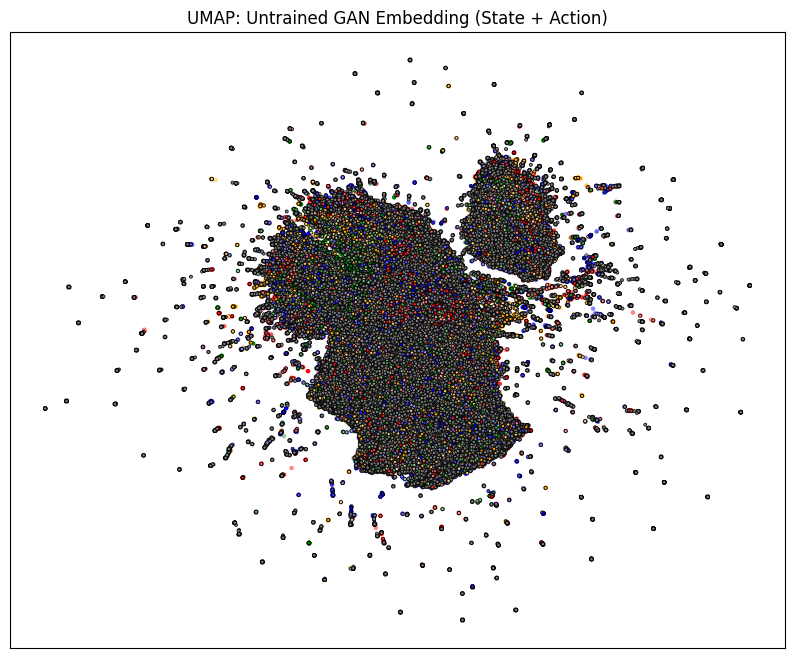

In [8]:

def generate_suit_colormap():
    # Define base colors for each suit
    suit_colors = {
        0: "#FF0000",  # Red (Suit 0)
        1: "#0000FF",  # Blue (Suit 1)
        2: "#008000",  # Green (Suit 2)
        3: "#FFA500"   # Orange (Suit 3)
    }

    # Generate a colormap where higher cards are lighter
    colormap = {}
    for suit in range(4):
        base_color = mcolors.to_rgb(suit_colors[suit])
        for card in range(9):
            lightness = 0.4 + 0.6 * (card / 8)  # Card 0 -> 0.4, Card 8 -> 1.0
            light_color = tuple(1 - (1 - c) * lightness for c in base_color)
            colormap[suit * 9 + card] = light_color

    return colormap

def plot_embedding_dynamic(embedding, labels, is_fake_mask, title="UMAP Embedding"):
    colormap = generate_suit_colormap()
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    # Convert labels to int list
    labels = labels.astype(int)

    # Generate color array for all points
    colors = np.array([colormap.get(label, "#808080") for label in labels], dtype=object)

    # Plot Real Cards
    real_indices = ~is_fake_mask
    ax.scatter(
        embedding[real_indices, 0],
        embedding[real_indices, 1],
        color=colors[real_indices],
        s=5,
        alpha=1
    )

    # Plot Fake Cards with black border
    fake_indices = is_fake_mask
    ax.scatter(
        embedding[fake_indices, 0],
        embedding[fake_indices, 1],
        color=colors[fake_indices],
        s=5,
        edgecolors='black',
        linewidths=0.5,
        alpha=1
    )

    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()


gan_labels_flat = torch.cat(gan_labels, dim=0).squeeze(1).numpy()
gan_untrained_labels_flat = torch.cat(gan_untrained_labels, dim=0).squeeze(1).numpy()
is_fake_mask = np.array([True] * len(gan_fake) + [False] * len(gan_real))
plot_embedding_dynamic(embedding_gan, gan_labels_flat, is_fake_mask, title="UMAP: GAN Embedding (State + Action)")
plot_embedding_dynamic(embedding_untrained, gan_untrained_labels_flat, is_fake_mask, title="UMAP: Untrained GAN Embedding (State + Action)")
